# 이미지에 적합한 신경망 구조, Convolutional Neural Network (CNN)


#1.합성곱 신경망 (Convolutional Neural Network) 이란?

합성곱 신경망은 합성곱 연산을 이용하여 가중치 필터 기반의 신경망 구조인 합성곱 층 (Convolution layer)와 입력 차원 축소층인 풀링(Pooling) 으로 이뤄진 신경망 구조를 뜻한다.

이미지, 영상, 음성, 시계열 데이터 등 다양한 유형의 데이터에서 사용이 가능하며 특히, 데이터의 국소적 정보를 효과적으로 학습시킬 수 있어 공간 정보 추출이 중요한 데이터의 경우 가장 많이 사용되어진다.


## 1.1 합성곱 신경망의 구조

- 합성곱 층 : 가중치 필터 기반의 신경망 구조를 가짐
- 구성 요소
    1. 필터 크기 (kernel size) : 가중치 필터의 크기 (h, w)
    2. 필터 개수 (channel size) : 독립적인 가중치 필터의 개수
    3. 스트라이드 (stride): 필터의 이동 거리
    4. 페딩 (padding) : 입력 데이터의 가장자리 채우기



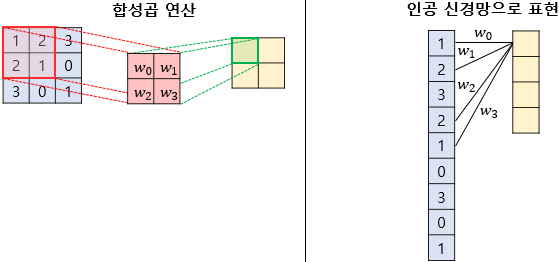

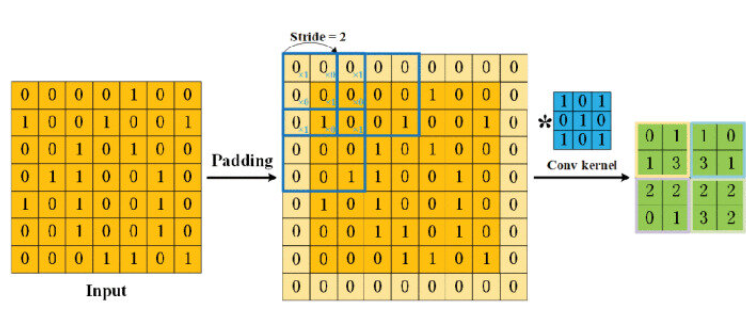

In [1]:
import torch
import torch.nn as nn

# 3채널(RGB) 입력, 64채널 출력, 3x3 커널, 스트라이드 1, 패딩 1
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
input_data = torch.randn(1, 3, 4, 4)  # (batch, channel, height, width)
output = conv(input_data)

print(output.shape)  # torch.Size([1, 16, 4, 4])

torch.Size([1, 16, 4, 4])


## 1.2 합성곱 신경망의 특징

- 파라미터 공유 (parameter sharing): 동일한 필터(가중치)로 여러 위치에 대해 합성곱 계산을 하기 때문에 파라미터 수가 적다.

- 이동 등변성 (translation equivariance): 데이터 내에 객체가 존재하는 위치나 방향이 변경되더라도 상관 없이 동일한 출력값을 얻을 수 있다.


## 1.3 풀링 층의 구조
입력 데이터의 공간적 크기를 줄이고, 중요한 특징만 남기기 위해 사용합니다. 대표적으로 **최대 풀링(Max Pooling)**과 **평균 풀링(Average Pooling)**이 있으며, 각각 torch.nn.MaxPool2d와 torch.nn.AvgPool2d 클래스로 구현합니다

- 구성 요소
    1. 풀링 크기 (pooling size) : 풀링 영역의 크기 (h, w)
    3. 스트라이드 (stride): 풀링 영역의 이동 거리


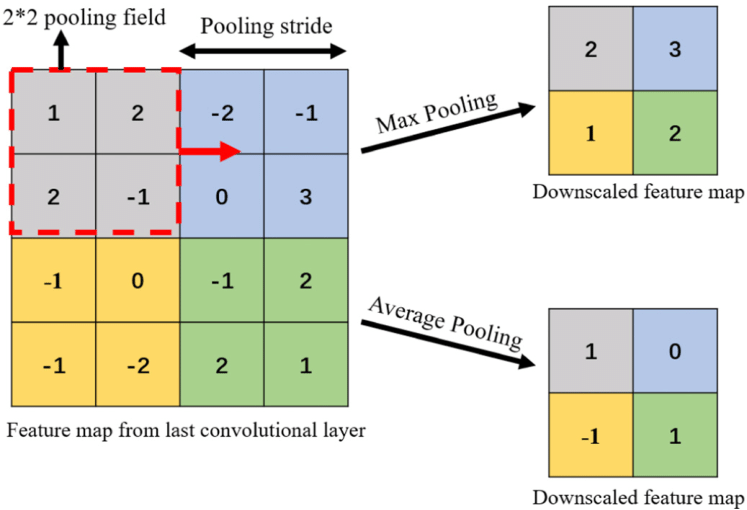

In [2]:
# pooling 층 계산 결과 확인하기
import torch.nn as nn

print(input_data[0][0])

# 2D Max Pooling: 2x2 윈도우, stride 2
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
maxpool_output = maxpool(input_data)
print(maxpool_output[0][0])
print(maxpool_output.shape)  # torch.Size([1, 3, 2, 2])

# 2D Average Pooling: 2x2 윈도우, stride 2
avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
avgpool_output = avgpool(input_data)
print(avgpool_output[0][0])
print(avgpool_output.shape)  # torch.Size([1, 3, 2, 2])


tensor([[-2.1201,  0.6507, -2.2646,  0.2547],
        [-1.0167,  0.2953, -1.4045, -0.1883],
        [ 1.4770,  0.4016, -0.1204, -1.7852],
        [ 0.1574, -0.2038, -0.3270,  0.4227]])
tensor([[0.6507, 0.2547],
        [1.4770, 0.4227]])
torch.Size([1, 3, 2, 2])
tensor([[-0.5477, -0.9007],
        [ 0.4580, -0.4525]])
torch.Size([1, 3, 2, 2])


## 2.1 간단한 CNN model 구성하기
- 구성 방식: 2층의 CNN (Conv + pooling layer) 과 1층의 완전 연결층 (FC)로 이뤄진 모델

In [3]:
class simple_CNN_model(nn.Module):
    def __init__(self, input_channel_size, output_channel_size, num_classes):
        super().__init__()
        # 합성곱 레이어 2층
        self.conv1 = nn.Conv2d(input_channel_size, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, output_channel_size, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # 출력 크기 1x1로 축소

        # 완전 연결 레이어 층
        self.fc = nn.Linear(output_channel_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.gap(x) # (batch, output_channel_size, 1, 1)

        x = x.view(x.size(0), -1) # 평탄화 (flatten)
        x = self.fc(x)
        return x

# 2.2 간단한 CNN model 로 MNIST 문제 해결하기

In [4]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.50MB/s]


torch.Size([1, 28, 28])
5
Epoch [1/50], Train Loss: 2.2785, Val Loss: 2.2336
Epoch [2/50], Train Loss: 2.1135, Val Loss: 2.0059
Epoch [3/50], Train Loss: 1.9537, Val Loss: 1.8846
Epoch [4/50], Train Loss: 1.7853, Val Loss: 1.6424
Epoch [5/50], Train Loss: 1.5283, Val Loss: 1.3853
Epoch [6/50], Train Loss: 1.3070, Val Loss: 1.1910
Epoch [7/50], Train Loss: 1.1420, Val Loss: 1.0160
Epoch [8/50], Train Loss: 1.0065, Val Loss: 0.9132
Epoch [9/50], Train Loss: 0.8980, Val Loss: 0.8185
Epoch [10/50], Train Loss: 0.8115, Val Loss: 0.7152
Epoch [11/50], Train Loss: 0.7374, Val Loss: 0.6464
Epoch [12/50], Train Loss: 0.6740, Val Loss: 0.7089
Epoch [13/50], Train Loss: 0.6192, Val Loss: 0.5790
Epoch [14/50], Train Loss: 0.5727, Val Loss: 0.5097
Epoch [15/50], Train Loss: 0.5346, Val Loss: 0.4990
Epoch [16/50], Train Loss: 0.4998, Val Loss: 0.4502
Epoch [17/50], Train Loss: 0.4716, Val Loss: 0.4194
Epoch [18/50], Train Loss: 0.4455, Val Loss: 0.4519
Epoch [19/50], Train Loss: 0.4207, Val Loss: 0.

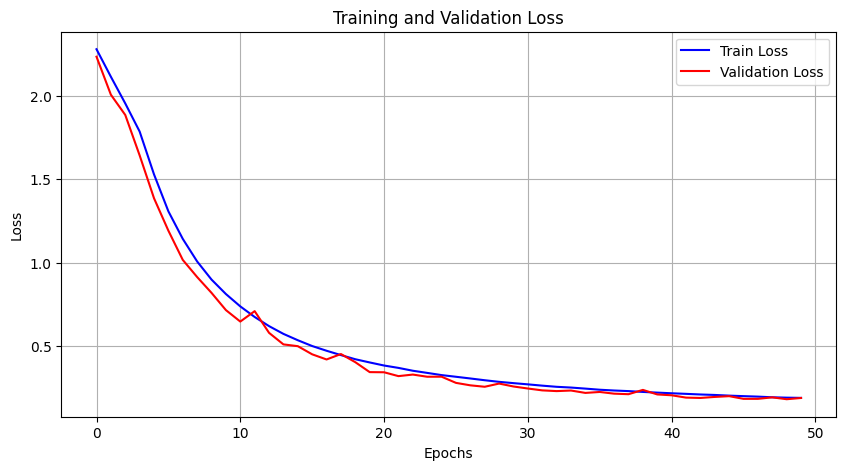

In [5]:
import torchvision
from torchvision import transforms


# MNIST 데이터 로드
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',  transform=transforms.ToTensor(), train=False)

image, label = train_dataset[0]
print(image.shape)  # torch.Size([1, 28, 28])
print(label)        # 5

# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# 하이퍼파라미터 설정
input_channel_size = 1    # 흑백
output_channel_size = 64   # 은닉층 유닛 수
num_classes = 10    # 0-9 숫자 분류
learning_rate = 1e-2

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = simple_CNN_model(input_channel_size, output_channel_size, num_classes).to(device)

# 손실 함수와 옵티마이져 설정하기
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 손실 기록 리스트
train_losses = []
val_losses = []

# 학습 루프
num_epochs = 50

# 학습
for epoch in range(num_epochs):
    model.train() # 학습을 알리는 flag
    running_loss = 0.0 # epoch 마다 평균 loss값 측정

    for images, labels in train_loader:
        images = images.to(device) # (batch, 1, 28, 28)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 검증
    model.eval() # 을 알리는 flag
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) # (batch, 1, 28, 28)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


# 테스트셋을 이용해 모델의 정확도 평가하기
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader: # 테스트 데이터 불러오기
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # 학습된 모델로부터 테스트 데이터의 예측 값 얻기
        _, predicted = torch.max(outputs.data, 1) # 가장 확률이 높은 숫자 값 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%') # 테스트 데이터셋의 전체 정확도

# 손실값 시각화
plot_losses(train_losses, val_losses)

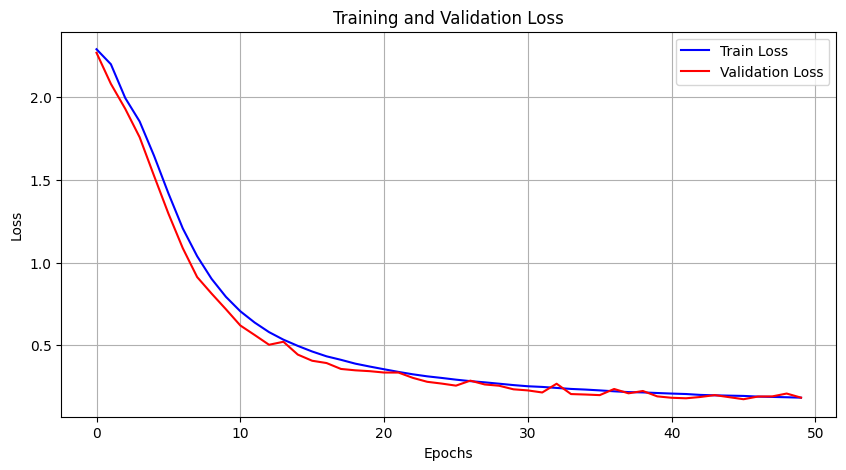

30~50 epoch 사이부터는 손실 값이 변화가 현저히 줄어드는 것을 확인할 수 있다.
이는 해당 구간에서 학습의 어려움을 겪는다는 것을 뜻함.

이를 해결하기 위해서는 다음의 질문이 가능하다.  

- 학습률 및 에폭은 얼마의 크기로 설정할 것인가?
- 모델을 구성함에 있어 히든 사이즈는 몇으로 해야하는 가?
- 신경망 층은 몇 층으로 쌓아야 하는 가?
- 활성화 함수는 무엇을 사용할 것인 가?
- 손실 함수와 옵티마이져는 무엇을 사용할 것인가?
- 혹여 모델의 학습에서 **과적합**을 불러일으키지는 않는 가?

# 해보기: CIFAR-10 데이터셋 학습시키기

CIFAR-10의 주요 특징

- 이미지 크기: 32x32 픽셀, 3채널(RGB) 컬러 이미지
- 클래스 수: 10개
airplane (비행기)
automobile (자동차)
bird (새)
cat (고양이)
deer (사슴)
dog (개)
frog (개구리)
horse (말)
ship (배)
truck (트럭)

- 데이터 분포: 학습 데이터: 50,000장 (각 클래스당 약 5,000장), 테스트 데이터: 10,000장 (각 클래스당 약 1,000장)

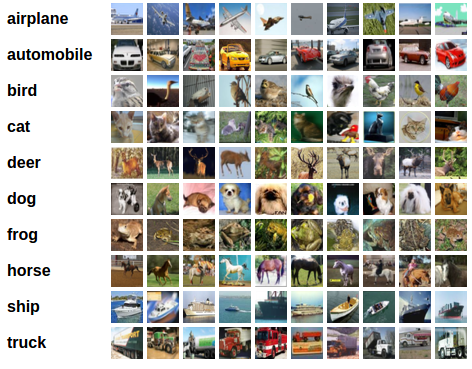

## 예시 코드

In [6]:
class custom_CNN_model(nn.Module):
    def __init__(self, input_channel_size, output_channel_size, num_classes):
        super().__init__()
        # 합성곱 레이어 4층
        self.conv1 = nn.Conv2d(input_channel_size, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, output_channel_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(output_channel_size, output_channel_size, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # 출력 크기 1x1로 축소

        # 완전 연결 레이어 층
        self.fc = nn.Linear(output_channel_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.gap(x) # (batch, output_channel_size, 1, 1)

        x = x.view(x.size(0), -1) # 평탄화 (flatten)
        x = self.fc(x)
        return x

100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


torch.Size([3, 32, 32])
6
Epoch [1/10], Train Loss: 2.2429, Val Loss: 2.1225
Epoch [2/10], Train Loss: 2.0801, Val Loss: 2.0448
Epoch [3/10], Train Loss: 1.9893, Val Loss: 1.9477
Epoch [4/10], Train Loss: 1.8841, Val Loss: 1.8611
Epoch [5/10], Train Loss: 1.8079, Val Loss: 1.7542
Epoch [6/10], Train Loss: 1.7358, Val Loss: 1.6850
Epoch [7/10], Train Loss: 1.6703, Val Loss: 1.6208
Epoch [8/10], Train Loss: 1.6066, Val Loss: 1.5986
Epoch [9/10], Train Loss: 1.5463, Val Loss: 1.5229
Epoch [10/10], Train Loss: 1.4918, Val Loss: 1.5343
Test Accuracy: 43.10%


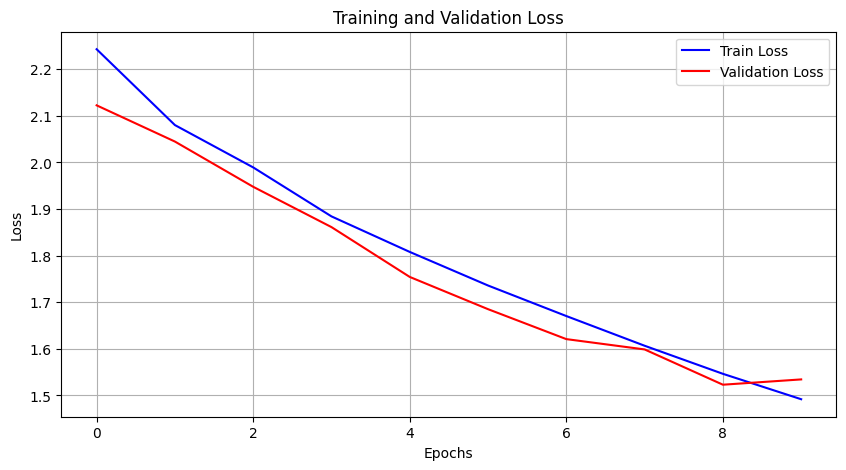

In [7]:
import torchvision
from torchvision import transforms


# MNIST 데이터 로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',  transform=transforms.ToTensor(), train=False)

image, label = train_dataset[0]
print(image.shape)  # torch.Size([3, 32, 32])
print(label)        # 5

# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# 하이퍼파라미터 설정
input_channel_size = 3    # 흑백
output_channel_size = 64   # 은닉층 유닛 수
num_classes = 10    # 0-9 숫자 분류
learning_rate = 1e-2

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = custom_CNN_model(input_channel_size, output_channel_size, num_classes).to(device)

# 손실 함수와 옵티마이져 설정하기
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 손실 기록 리스트
train_losses = []
val_losses = []

# 학습 루프
num_epochs = 10

# 학습
for epoch in range(num_epochs):
    model.train() # 학습을 알리는 flag
    running_loss = 0.0 # epoch 마다 평균 loss값 측정

    for images, labels in train_loader:
        images = images.to(device) # (batch, 3, 32, 32)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 검증
    model.eval() # 을 알리는 flag
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) # (batch, 3, 32, 32)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


# 테스트셋을 이용해 모델의 정확도 평가하기
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader: # 테스트 데이터 불러오기
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # 학습된 모델로부터 테스트 데이터의 예측 값 얻기
        _, predicted = torch.max(outputs.data, 1) # 가장 확률이 높은 숫자 값 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%') # 테스트 데이터셋의 전체 정확도

# 손실값 시각화
plot_losses(train_losses, val_losses)